# Fourier Transform Model of Image Formation

The Fourier transform (FT) transform is one among the many classes of linear transforms that recast information into a set of linear basis functions. In particular, FT converts a signal with  physical dimension $x$ into a signal with dimension $\frac{1}{x}$ using sinusoids as basis functions. If the signal has dimensions of space, the FT of the signal will have dimensions of inverse space or spatial frequency.

The 2D FFT has the following properties:
1. The output of FFT2 has quadrants along the diagonals interchanged. That is if the quadrants are labeled in the clockwise direction as $\begin{bmatrix} 4&1\\3&2 \end{bmatrix}$, the FFT output comes out as $\begin{bmatrix} 2&4\\1&3 \end{bmatrix}$. The function `fftshift()` interchanges the quadrants back.
2. The output of the FFT2 is a complex number array. To view the intensity, use `abs()` function which computes the modulus of the a complex number.
3. The inverse FFT2 , `ifft2()`, is just the same as the forward fft2( ) only that the output image may be upside down.

In [200]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw, ImageFont

plt.rcParams["figure.figsize"] = (4,4)
# plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 300

In [220]:
def aperture_fft(aperture_shape):
    fig, ax = plt.subplots(1, 3, figsize = (9, 4), sharey = True, tight_layout = True)
    ax[0].imshow(aperture_shape, cmap = "gray")
    ax[0].set_title("Aperture")
    
    fft_aperture = fft.fft2(aperture_shape)
    ax[1].imshow(abs(fft_aperture), cmap = "hot")
    ax[1].set_title("Fourier transform of aperture")
    
    fftshift_aperture = fft.fftshift(fft_aperture)
    ax[2].imshow(abs(fftshift_aperture), cmap = "hot")
    ax[2].set_title("Corrected quadrant positions")


## Activity 2.1 - Familiarization with Discrete FT

### Circular aperture

In [212]:
def circular_aperture(radius, resolution):
    N = resolution
    x = np.linspace(-1, 1, N)
    y = x
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    
    aperture = np.zeros(np.shape(R))
    aperture = np.where((R<radius), 1, 0)
    
    return aperture

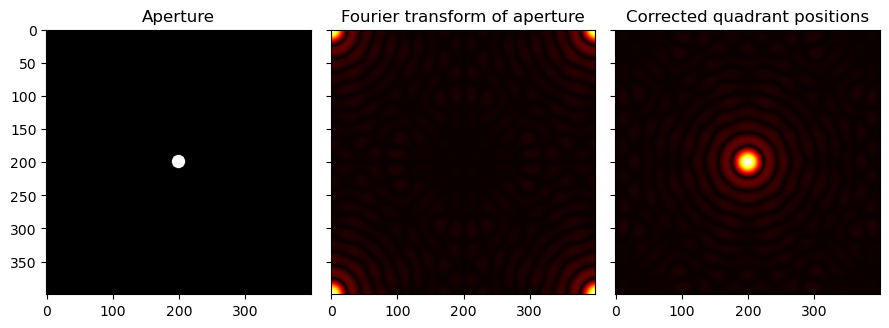

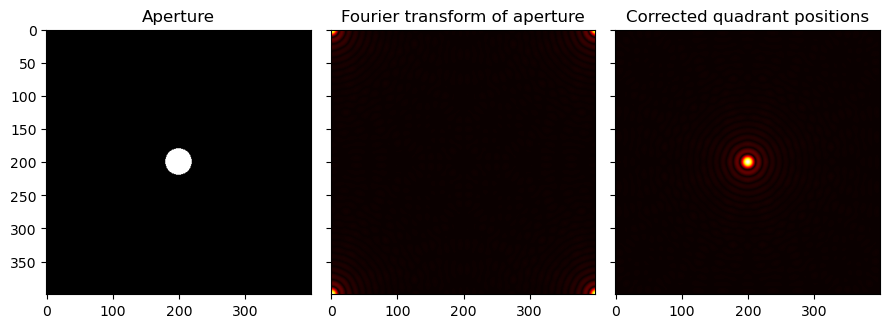

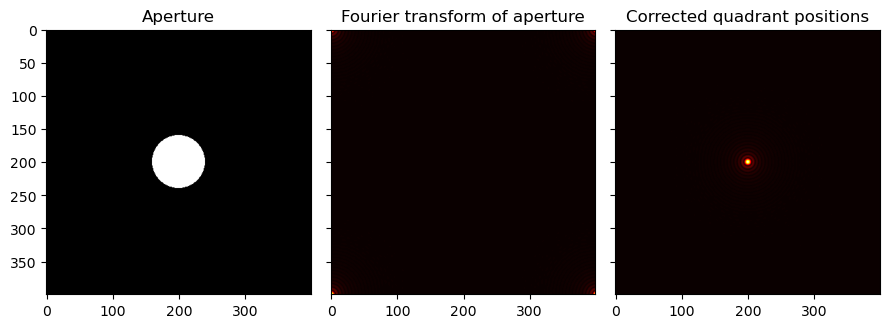

In [221]:
radius = [0.05, 0.1, 0.2]

for rad in radius:
    aperture_fft(circular_aperture(rad, 400))
    plt.savefig("radius {}.png".format(rad))

### Rectangular aperture

In [93]:
def rectangular_aperture(width, height, resolution):
    aperture = np.zeros((resolution, resolution), float)
    center = [resolution/2, resolution/2]
    width_array = np.arange(center[0] - width//2, center[0] + width//2)
    height_array = np.arange(center[1] - height//2, center[1] + height//2)
    for w in width_array:
        for h in height_array:
            aperture[int(h)][int(w)] = 1.0
            
    return aperture

#### Varying heights

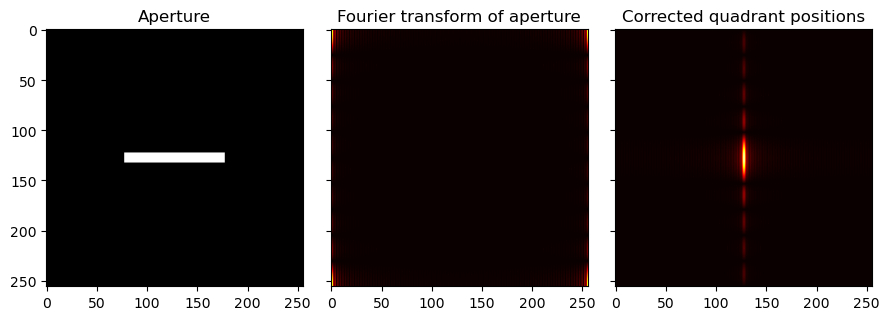

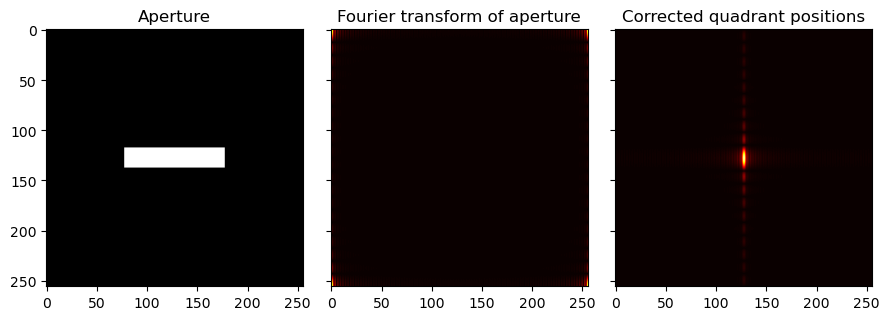

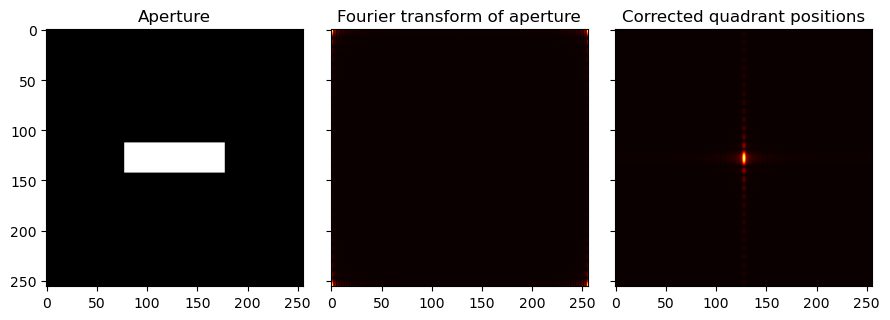

In [108]:
height = [10, 20, 30]

for h in height:
    aperture_fft(rectangular_aperture(100, h, 256))
    plt.savefig("height {}.png".format(h))

#### Varying widths

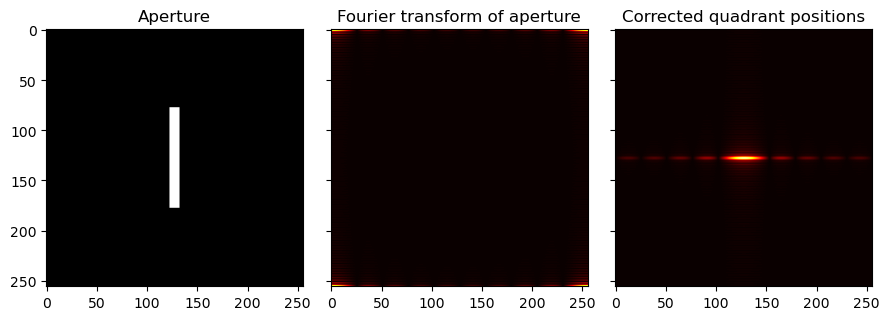

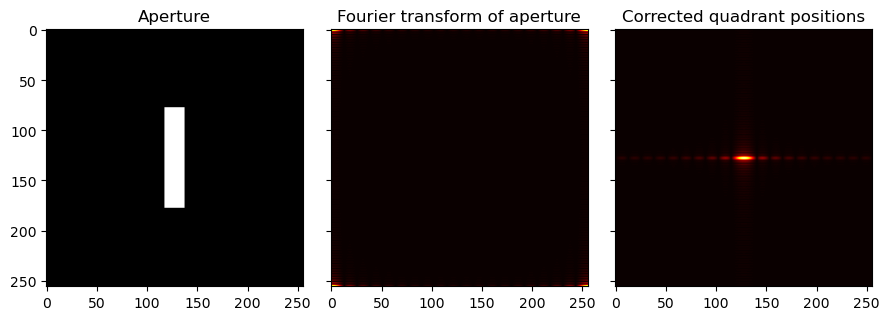

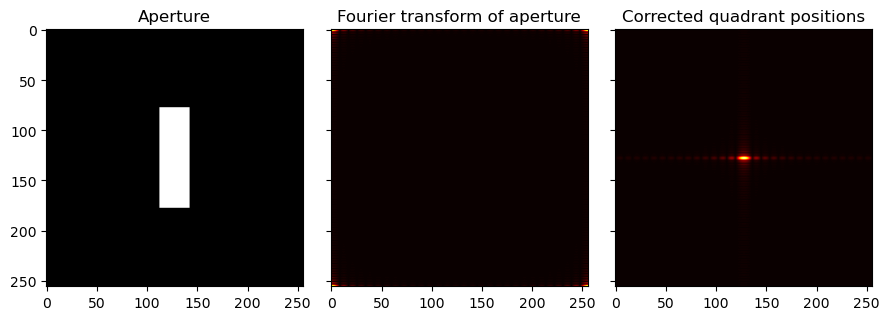

In [107]:
width = [10, 20, 30]

for w in width:
    aperture_fft(rectangular_aperture(w, 100, 256))
    plt.savefig("width {}.png".format(w))

### Double slit aperture

In [91]:
def double_slit(width, height, distance, resolution):
    aperture = np.zeros((resolution, resolution), float)
    center = [resolution/2, resolution/2]
    slit_center = [center[0] - distance/2, center[0] + distance/2]
    slitwidth_array1 = np.arange(slit_center[0] - width, slit_center[0])
    slitwidth_array2 = np.arange(slit_center[1], slit_center[1] + width)
    slitheight_array = np.arange(center[0] - height//2, center[0] + height//2)
    
    for w1 in slitwidth_array1:
        for w2 in slitwidth_array2:
            for h in slitheight_array:
                aperture[int(h)][int(w1)] = 1.0
                aperture[int(h)][int(w2)] = 1.0
            
    return aperture

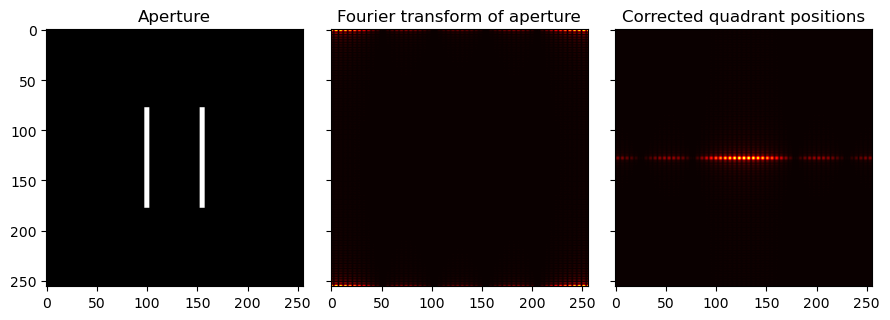

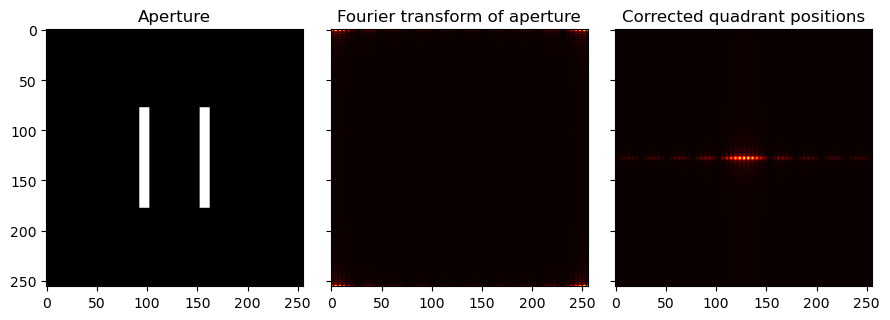

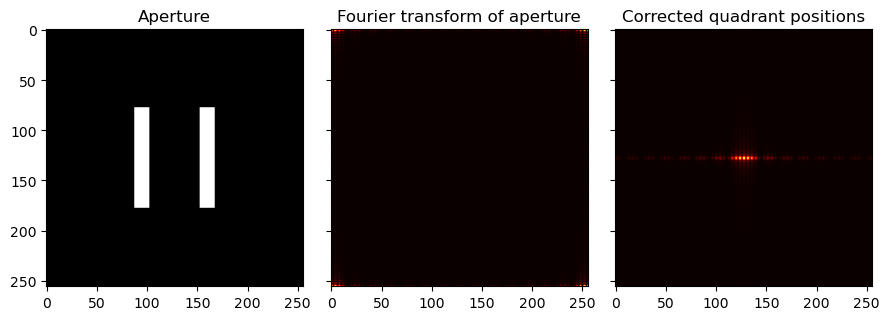

In [114]:
slitwidth = [5, 10, 15]

for w in slitwidth:
    aperture_fft(double_slit(w, 100, 50, 256))
    plt.savefig("slit wdith {}.png".format(w))

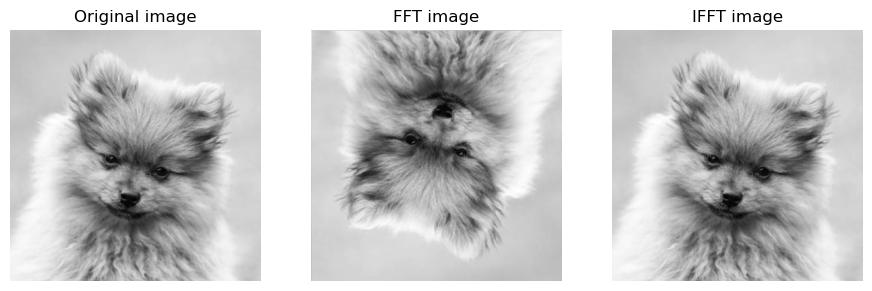

In [58]:
croppedimg = Image.open("cropped dog.png")
grayimg = np.array(croppedimg.convert("L"))

fft2_dog = fft.fft2(fft.fft2(grayimg))
ifft2_dog = fft.ifft2(fft.fft2(grayimg))

fig, ax = plt.subplots(1, 3, figsize = (11, 6), sharey = True)
ax[0].imshow(grayimg, cmap = "gray")
ax[0].set_title("Original image")
ax[1].imshow(abs(fft2_dog), cmap = "gray")
ax[1].set_title("FFT image")
ax[2].imshow(abs(ifft2_dog), cmap = "gray")
ax[2].set_title("IFFT image")

for i in range(3):
    ax[i].axis("off")

## Activity 2.2 - Simulation of an imaging system

### Convolution
The convolution between two 2-D functions $f$ and $g$ is given by $$ h(x,y) = f*g = \iint f(x',y') g(x-x',y-y') d{x'} d{y'} $$

The convolution is a linear operator which means that if $f$ and $g$ are recast by linear transformations such as the Laplace or Fourier transform, they obey the convolution theorem, $$H=FG$$.

where $H$, $F$ and $G$ are the transforms of $h$, $f$ and $g$ respectively. This means, a convolution in 2-D space is a multiplication in Fourier space. The code for plotting such text image was patterned from this [site](https://www.geeksforgeeks.org/python-pil-imagedraw-draw-text/).

In [147]:
def textimg_generate(x, y, fontsize, resolution = 256, text = None):
    background = Image.new("L", (resolution, resolution), color = "black")
    font = ImageFont.truetype("C:/Windows/Fonts/Arial/ariblk.ttf", fontsize)
    textimg = ImageDraw.Draw(background)
    textimg.text((x, y), text, font = font, fill = "white")
    return background

We convolve these two images together and observe how one image is smeared against another image.

In [182]:
def convolve(image1, image2): # image1 is the text and image2 is the lens
    fftshift_lens = fft.fftshift(image2)
    fft2_text = fft.fft2(image1)
    convolved_image = fftshift_lens*fft2_text
    ifft2_image = fft.ifft2(convolved_image)
    plt.imshow(abs(ifft2_image), cmap = "gray")

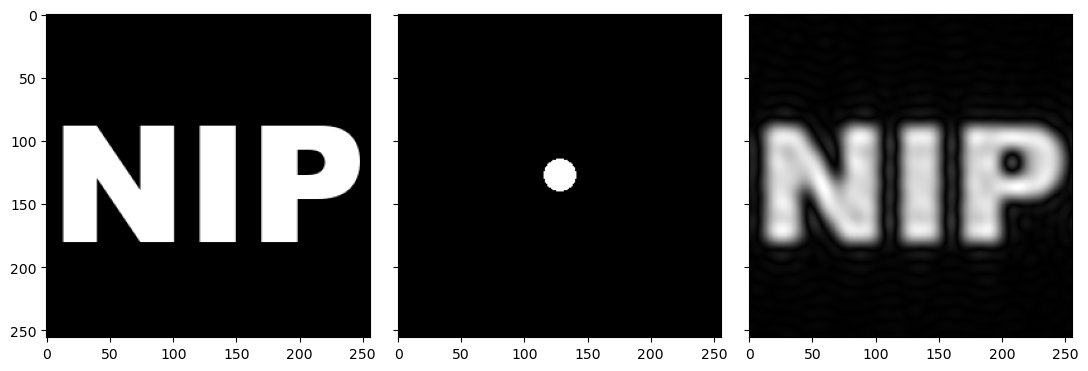

In [198]:
NIPtext = textimg_generate(4, 40, 128, text = "NIP")
lens_aperture = circular_aperture(0.1, 256)

fig, ax = plt.subplots(1, 3, figsize = (11, 6), sharey = True, tight_layout = True)
ax[0].imshow(NIPtext, cmap = "gray")
ax[1].imshow(lens_aperture, cmap = "gray")
ax[2] = convolve(NIPtext, lens_aperture)

In [ ]:
aperture_radius = 